In [39]:
# Import all of the python packages used in this workflow.
import scipy
import numpy as np
from collections import OrderedDict
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osr
import xarray as xr
import geopandas as gpd
from datetime import datetime
from datetime import timedelta  
import json
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.plot
from matplotlib.colors import ListedColormap
import seaborn as sns
import earthpy.spatial as es
import earthpy.plot as ep
import cartopy.crs as ccrs

In [154]:
######### USER #########
#select domain
domain = 'WA'

In [155]:
#SWE data path
swepath = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/CSO_SNOTEL_data_SWEDmeters.csv'

#SNOD data path
snodpath = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/CSO_SNOTEL_data_SNODmeters.csv'

#station path 
station_path = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/CSO_SNOTEL_sites.geojson'

#fig paths 
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'

# raster path
raster_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'

In [156]:
gdf = gpd.read_file(station_path)
df = pd.read_csv(swepath,index_col=0) 
gdf.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,515_WA_SNTL,-120.658600,48.720470,Harts Pass,1978.1519775390625,672206.061972,5.399027e+06,POINT (-120.65860 48.72047)
1,1259_WA_SNTL,-119.866241,48.585258,Muckamuck,1362.4560546875,731093.783565,5.386094e+06,POINT (-119.86624 48.58526)
2,681_WA_SNTL,-120.915512,48.444881,Park Creek Ridge,1402.0799560546875,654147.805738,5.367848e+06,POINT (-120.91551 48.44488)
3,711_WA_SNTL,-120.735802,48.518650,Rainy Pass,1490.4720458984375,667193.866770,5.376424e+06,POINT (-120.73580 48.51865)
4,728_WA_SNTL,-119.838303,48.655182,Salmon Meadows,1359.407958984375,732831.734842,5.393950e+06,POINT (-119.83830 48.65518)


# Station plot

In [164]:
import cartopy.crs as ccrs
import numpy as np

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [163]:
# DEM data
#pathToRaster = r'/nfs/attic/dfh/Aragon2/CSOdmn/WY/DEM_WY.tif'
src = rio.open(raster_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
elevation = src.read(1)

print(minx,miny,maxx,maxy)
#plot
x = plt.imshow(src.read(1), cmap='gray')
plt.show()

ModuleNotFoundError: No module named 'matplotlib_scalebar'

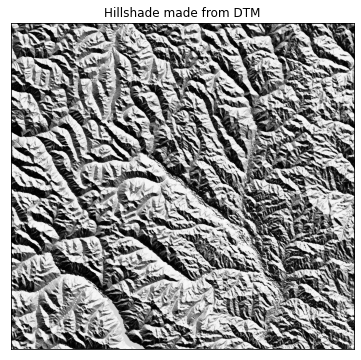

In [158]:
# Create and plot the hillshade with earthpy
hillshade = es.hillshade(elevation)

ep.plot_bands(
    hillshade, cbar=False, title="Hillshade made from DTM", figsize=(10, 6)
)
plt.show()

In [159]:
stn = gpd.read_file(station_path)
new=stn.to_crs('epsg:32610')
new.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,515_WA_SNTL,-120.658600,48.720470,Harts Pass,1978.1519775390625,672206.061972,5.399027e+06,POINT (672206.062 5399027.491)
1,1259_WA_SNTL,-119.866241,48.585258,Muckamuck,1362.4560546875,731093.783565,5.386094e+06,POINT (731093.784 5386094.282)
2,681_WA_SNTL,-120.915512,48.444881,Park Creek Ridge,1402.0799560546875,654147.805738,5.367848e+06,POINT (654147.806 5367847.622)
3,711_WA_SNTL,-120.735802,48.518650,Rainy Pass,1490.4720458984375,667193.866770,5.376424e+06,POINT (667193.867 5376424.178)
4,728_WA_SNTL,-119.838303,48.655182,Salmon Meadows,1359.407958984375,732831.734842,5.393950e+06,POINT (732831.735 5393950.294)


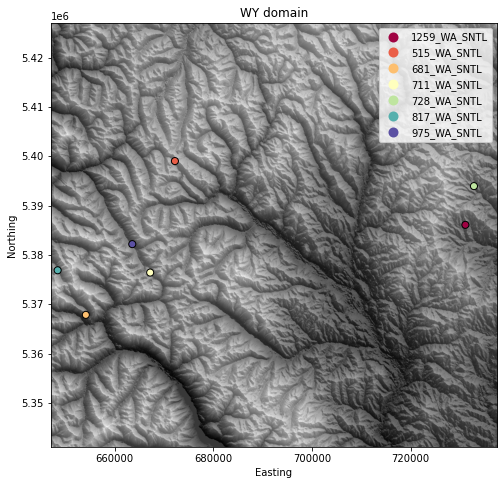

In [160]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(8,10))

#hillshade and elevation
ax.imshow(np.flipud(hillshade), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray')
ax.imshow(np.flipud(elevation), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# title
plt.title('WY domain')

#stations
new.plot(column='code',legend=True, ax=ax,markersize=50,edgecolors='k',cmap=cmap)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1,1))


#plt.savefig(f"/nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/test.png")#Python_Animation_02_frame_{i:04}.png")
plt.show()

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


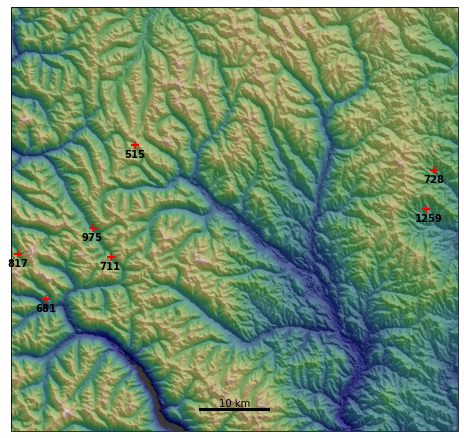

In [168]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(8,10))

#this was added for the scalebar
ax = plt.axes(projection=ccrs.Mercator())

#hillshade and elevation
ax.imshow(np.flipud(hillshade), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray')
ax.imshow(np.flipud(elevation), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap='gist_earth', alpha = 0.7)

# #remove tickmarks and tick labels
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)

# #colorbar
# ax_cbar =plt.colorbar(snow,orientation="vertical")#, fraction=0.07)
# ax_cbar.set_label('SWE [m]')

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

#https://gist.github.com/dmeliza/3251476 scalebar?
#https://www.thetopsites.net/article/50674451.shtml
scale_bar(ax, 10)

#date title
#plt.title('WY domain')

new.plot(column='code',legend=False, ax=ax,markersize=50,edgecolors=None,color='r',marker='+')

new['code_short']= [row[:-8] for row in new['code']]

for x, y, label in zip(new.geometry.x, new.geometry.y, new.code_short):
    ax.annotate(label, xy=(x, y), xytext=(-11, -13), textcoords="offset points",weight='bold',fontsize=10, color = 'k')#,rotation = 20)

plt.show()

In [162]:
fig.savefig(figpath+domain+'_map.pdf', format='pdf', dpi=300)

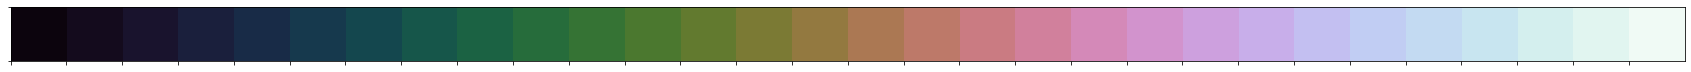

In [62]:
from matplotlib.colors import ListedColormap
import seaborn as sns
cmap = ListedColormap(sns.color_palette("Spectral",200))  
clrs = sns.palplot(sns.color_palette("cubehelix",30))

#cmap = sns.cubehelix_palette(30,as_cmap=True)


pal = sns.dark_palette("palegreen", as_cmap=True)

cmap = ListedColormap(sns.color_palette("Spectral",200))   

# SWE

In [6]:
df_depth = pd.read_csv(snodpath,index_col=0) 
df_depth.head()

,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,379_WY_SNTL,419_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,497_WY_SNTL,...,764_WY_SNTL,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL
2014-10-01,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,NaN,0.0508,0.0,...,0.0,0.0,0.0,0.0254,0.0,0.0,0.0,0.0,0.0762,0.0
2014-10-02,0.0,0.0,0.0508,0.0,0.0,0.0,0.0,NaN,0.1016,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0762,0.0
2014-10-03,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,NaN,0.1270,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0508,0.0
2014-10-04,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,NaN,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0
2014-10-05,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,NaN,0.0000,0.0,...,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0


In [47]:
x = df['314_WY_SNTL'].values.reshape(5,365)
#new = np.reshape(x, (365,(int(len(x)/365))))
print(shape(x))
av = np.mean(x,0)
shape(av)

(5, 365)


(365,)

In [52]:
import cycler

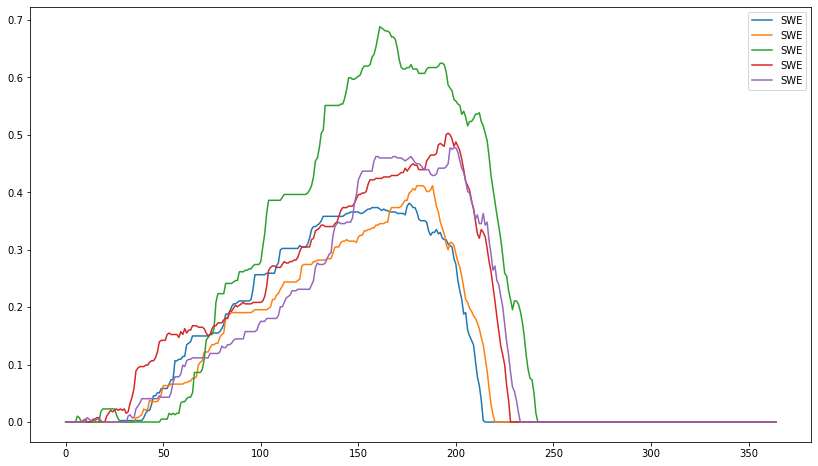

In [51]:
fig, axs = plt.subplots(figsize=(14, 8))
axs.plot(np.transpose(x),label = 'SWE')
axs.legend()

In [ ]:
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    x = df[nam].values.reshape(5,365)

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=6)
fig.subplots_adjust(hspace=0.5)
#fig.suptitle('Distributions of Iris Features')
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    x = df[nam].values.reshape(5,365)
    for ax, feature, name in zip(axes.flatten(), data.data.T, data.feature_names):
        ax.plot(np.transpose(x))
        #ax.set(title=name[:-4].upper(), xlabel='cm')

In [ ]:
x = df[nam].values.reshape(5,365)
    inputs = np.transpose(x)

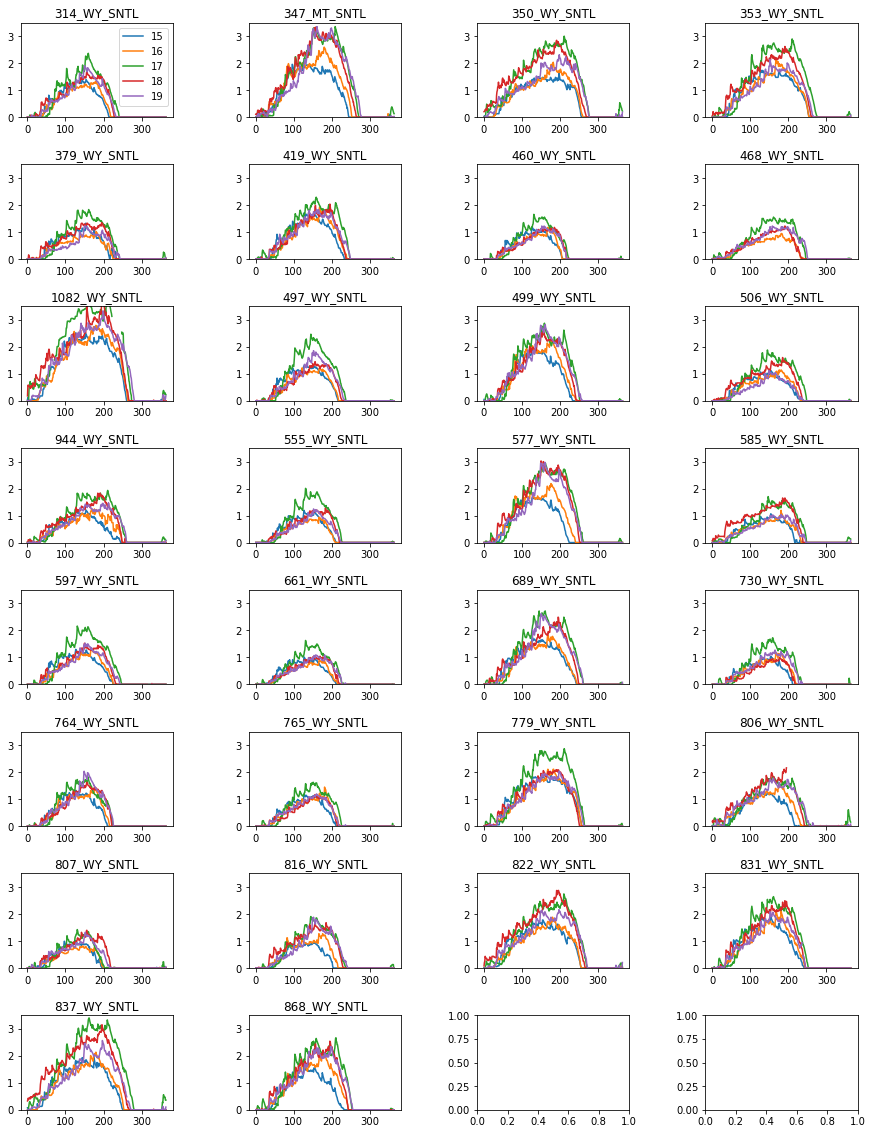

In [44]:
station = gdf['code'].values
labels = ['15', '16', '17','18','19']

fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(15, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    x = df_depth[nam].values.reshape(5,365)
    axs[i].plot(np.transpose(x),label=labels)
    axs[i].set_title(nam)
    axs[i].set_ylim([0, 3.5])
    if i == 0:
        axs[i].legend(['15', '16', '17','18','19'])

In [45]:
filename = figpath+'station_DEPTH.pdf'
fig.savefig(filename, format='pdf', dpi=300)

# Density

/nfs/stak/users/aragonch/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/nfs/stak/users/aragonch/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nfs/stak/users/aragonch/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/nfs/stak/users/aragonch/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nfs/stak/users/aragonch/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/nfs/stak/users/aragonch/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykern

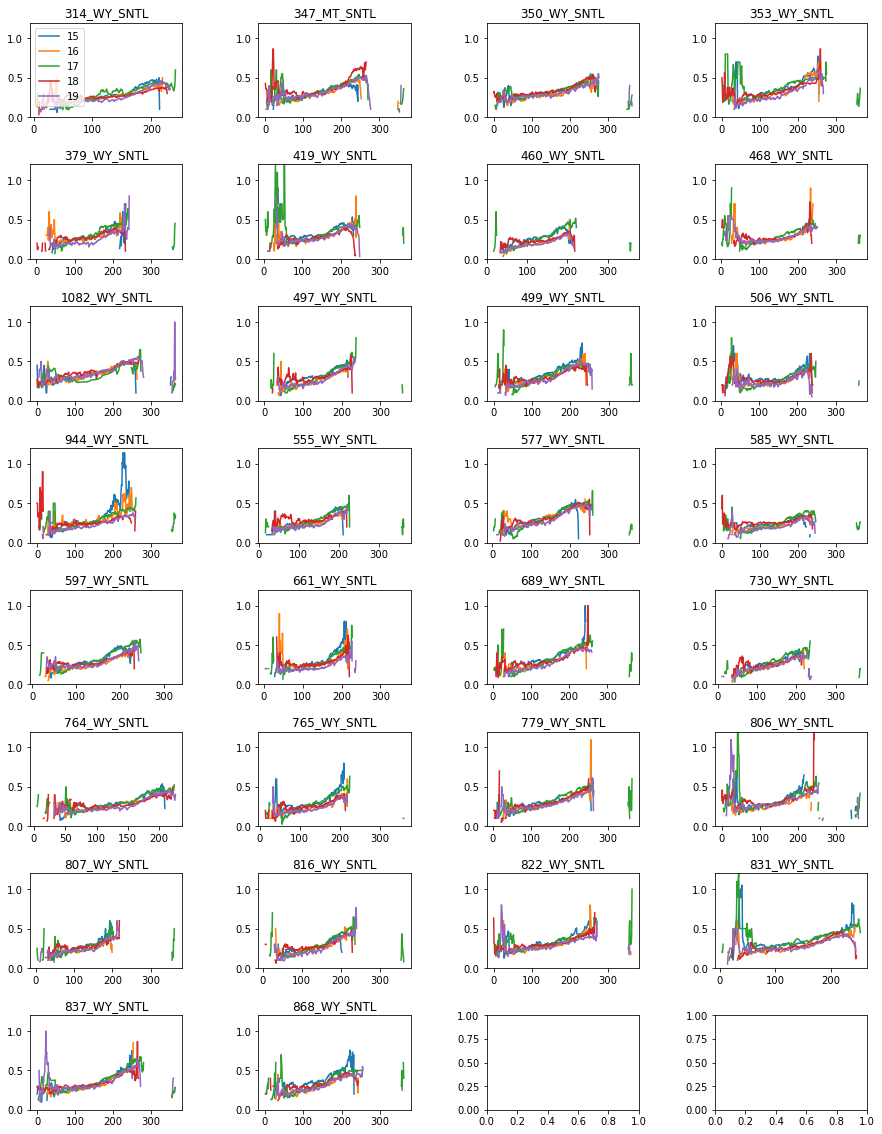

In [52]:
station = gdf['code'].values
labels = ['15', '16', '17','18','19']

fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(15, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    depth = df_depth[nam].values.reshape(5,365)
    swe = df[nam].values.reshape(5,365)
    density = swe/depth
    axs[i].plot(np.transpose(density),label=labels)
    axs[i].set_title(nam)
    axs[i].set_ylim([0,1.2])
    if i == 0:
        axs[i].legend(['15', '16', '17','18','19'])

In [53]:
filename = figpath+'station_RHO.pdf'
fig.savefig(filename, format='pdf', dpi=300)